# Project setup

Import necessary libraries

In [1]:
# System
import os
import shutil
import glob

# Image handling
from PIL import Image, ImageOps

# Numerical
import numpy as np
import pandas as pd

# Reproducability
import random
random.seed(42)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

First we establish the directory to where our data is stored, and where we ultimately want to store our cleaned, preprocessed data.

In [2]:
INIT_DIR = 'chinese-handwriting-recognition-hsk-1/chinese-handwriting/'

INIT_TRAIN_DIR = os.path.join(INIT_DIR, 'CASIA-HWDB_Train/Train/')
INIT_TEST_DIR = os.path.join(INIT_DIR, 'CASIA-HWDB_Test/Test/')

DIR = 'data/'

# Data investigation

First lets have a look at how many data classes we have in the dataset. The dataset has been split into test and train already so lets check how many classes we have in each.

In [3]:
image_classes_train = os.listdir(INIT_TRAIN_DIR)
image_classes_test = os.listdir(INIT_TEST_DIR)
print(len(image_classes_train), image_classes_train)
print(len(image_classes_test), image_classes_test)

if image_classes_train == image_classes_test:
    print('The same classes are in each folder')
    # image_classes = ['零', '一', '二']
    # image_classes = ['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十']
    image_classes = image_classes_train[:100]
    # image_classes = image_classes_train
else:
    print('The two folders contain different classes')

178 ['火', '分', '水', '谁', '工', '么', '喜', '七', '月', '租', '姐', '读', '喂', '坐', '商', '汉', '吃', '店', '了', '叫', '作', '说', '写', '兴', '字', '中', '车', '做', '书', '后', '年', '话', '多', '零', '喝', '关', '块', '日', '好', '漂', '苹', '在', '六', '那', '生', '他', '京', '狗', '点', '少', '会', '北', '起', '些', '欢', '明', '候', '是', '果', '买', '里', '子', '昨', '菜', '雨', '站', '谢', '杯', '十', '都', '高', '校', '能', '椅', '没', '们', '机', '午', '视', '有', '九', '语', '打', '同', '再', '人', '上', '和', '妈', '师', '一', '猫', '电', '呢', '桌', '钟', '气', '听', '你', '识', '前', '小', '影', '这', '很', '吗', '朋', '星', '老', '请', '期', '认', '今', '开', '下', '的', '学', '本', '亮', '钱', '先', '见', '爸', '飞', '院', '友', '二', '天', '服', '哪', '怎', '西', '四', '睡', '岁', '名', '样', '回', '医', '家', '习', '出', '国', '看', '八', '冷', '觉', '衣', '馆', '系', '米', '住', '饭', '三', '东', '去', '现', '时', '热', '面', '对', '茶', '脑', '想', '她', '太', '大', '来', '个', '儿', '五', '我', '女', '爱', '什', '几', '不', '客']
178 ['火', '分', '水', '谁', '工', '么', '喜', '七', '月', '租', '姐', '读', '喂', '坐', '商', '汉', '吃', '店', '了', '叫', 

Next, lets combine the the train and test data into one directory for simplicity.

We start by creating a new directory for our preprocessed data.

In [4]:
# Remove old data
if os.path.exists(DIR):
    shutil.rmtree(DIR)
    
#Create the new directory
os.mkdir(DIR)
for image_class in image_classes:
    path = os.path.join(DIR, image_class)
    os.makedirs(path)

Now let's combine the train and test data into one directory. This is specified by the `DIR` variable.

In [5]:
for image_class in image_classes:
    images = []

    # Fetch images from train dir
    train_path = os.path.join(INIT_TRAIN_DIR, image_class)
    images += [os.path.join(train_path, file) for file in os.listdir(train_path)]

    # Fetch images from test dir
    test_path = os.path.join(INIT_TEST_DIR, image_class)
    images += [os.path.join(test_path, file) for file in os.listdir(test_path)]

    # Iterate over the splits and images and copy them to the data directory
    for i, image in enumerate(images):
        new_filename = f"{i+1}.png"
        destination_path = os.path.join(DIR, image_class, new_filename)
        shutil.copy(image, destination_path)

# Data Pre-processing

First lets iterate through all the images and and confirm they are all `.png` and black & white 

In [6]:
# Loop through each subdirectory and file in the directory
for subdir, dirs, images in os.walk(DIR):
    for image in images:
        if image.lower().endswith('.png'):
            file_path = os.path.join(subdir, image)

            with Image.open(file_path) as img:
                if img.mode != 'L':
                    print(f"{file_path} is not grayscale.")
        else:
            print("Not a png file: ")

Next let's iterate through all the images and check if any have an aspect ratio that is not 1:1.

In [7]:
image_sizes = []

# Iterate through all the images and check if any do not have a 1:1 aspect ratio
for subdir, dirs, images in os.walk(DIR):
    for image in images:
        file_path = os.path.join(subdir, image)
        with Image.open(file_path) as img:
            image_sizes.append(img.size[0])

            if img.size[0] != img.size[1]:
                print(file_path, img.size)

Since all the images are square, this makes it easier to investigate their image sizes.

Smallest dimension: 3


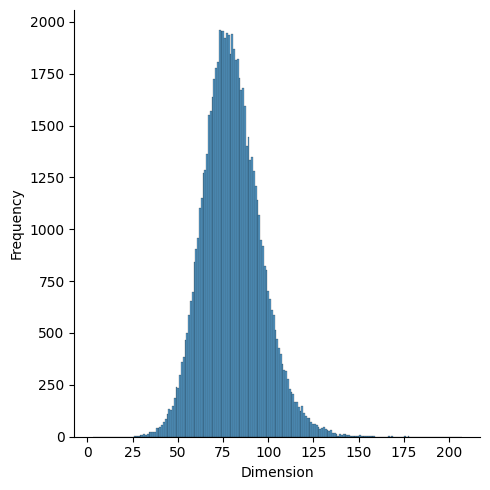

In [8]:
print(f"Smallest dimension: {min(image_sizes)}")

# Plotting
sns.displot(image_sizes)
plt.xlabel('Dimension')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Before we begin resizing images, let's have a look at the general statistics of how many samples are in each class.

In [9]:
def get_class_counts():
    class_counts = {}
    
    for subdir in glob.glob(os.path.join(DIR, '*')):
        file_count = len(glob.glob(os.path.join(subdir, '*')))
        class_counts[subdir.split('/')[-1]] = file_count

    return pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])

df_class_counts = get_class_counts() 
print(df_class_counts.describe([0.05, 0.25, 0.75, 0.95]))

            Count
count  100.000000
mean   741.220000
std      2.676422
min    732.000000
5%     737.000000
25%    740.000000
50%    741.000000
75%    743.000000
95%    746.000000
max    748.000000


As you can see from the graph, the images are not all the same size. This will cause issues when we try to train the model, so we need to resize all the images to the same size. Additionally one of the images is only 3x3 which is way too small to be useful, so we will enforce a minimum image size.

In [10]:
MIN_IMAGE_SIZE = 20
IMAGE_SIZE = 64

# Iterate through all the images and resize to a fixed size
for subdir, dirs, images in os.walk(DIR):
    for image in images:
        file_path = os.path.join(subdir, image)
        with Image.open(file_path) as img:
            current_size = img.size[0]
            if current_size < MIN_IMAGE_SIZE:
                os.remove(file_path)
                continue
            
            resized_img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            resized_img.save(file_path)

Now lets check how many images we have in each class and see how balanced the classes are.

In [11]:
df_class_counts = get_class_counts() 
print(df_class_counts.describe([0.05, 0.25, 0.75, 0.95]))

            Count
count  100.000000
mean   741.190000
std      2.665511
min    732.000000
5%     737.000000
25%    740.000000
50%    741.000000
75%    743.000000
95%    746.000000
max    748.000000


From this we can see that the classes are fairly balanced, let's quickly have a look at the slight imbalance in the classes.
We can arbitrarily choose a balance metric such as outside the range of 2 standard deviations from the mean.

In [12]:
df_class_counts = get_class_counts() 

mean = df_class_counts['Count'].mean()
std = df_class_counts['Count'].std()
threshold = 2 * std

outlier_counts = df_class_counts[np.abs(df_class_counts['Count'] - mean) > threshold]
print(outlier_counts)

   Count
月    748
零    732
在    747
六    733
雨    747
站    747


As we can see, the imbalance is minimal. For simplicity we will balance the classes by removing the excess images from the classes with more images than the minimum.

In [13]:
minimum_count = df_class_counts['Count'].min()
SAMPLES_PER_CLASS = minimum_count - (minimum_count % 10)
SAMPLES_PER_CLASS

730

Let's have a look some examples of the images in the dataset.

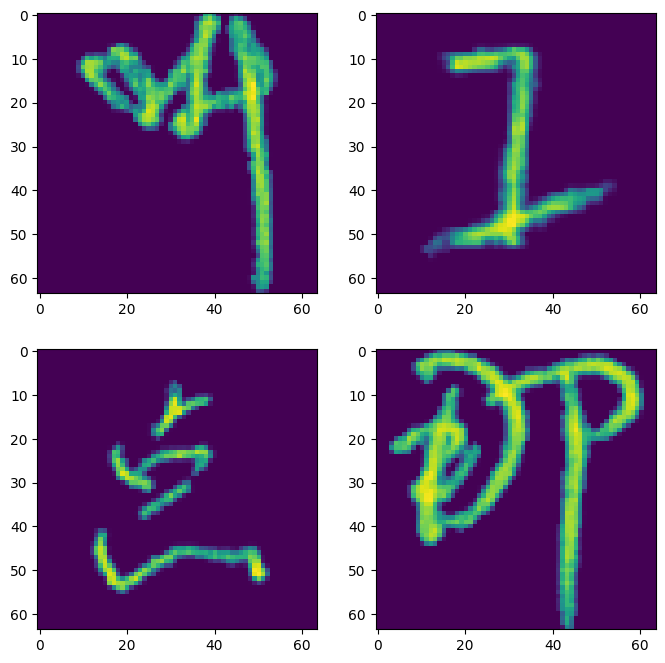

In [14]:
import glob

# Get list of all .png images in the directory and its subdirectories
images = glob.glob(os.path.join(DIR, '**', '*.png'), recursive=True)

# Randomly select num_images images
random_images = random.sample(images, 4)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    for j in range(2):
        img_path = random_images[2 * i + j]
        img = Image.open(img_path)
        img = ImageOps.invert(img)
        axs[i][j].imshow(img)

# NumPy Array Conversion

Now we can convert all the images into one single numpy array with the corresponding labels for each image.

In [15]:
image_list = []
label_list = []

for subdir, dirs, files in os.walk(DIR):
    if not files:
        continue
    
    for i in range(SAMPLES_PER_CLASS):
        file = files[i]
        
        file_path = os.path.join(subdir, file)
        label = subdir.split('/')[-1]

        img = Image.open(file_path)
        img_array = np.array(img)

        image_list.append(img_array)
        label_list.append(label)


Now we can convert the python lists into numpy arrays.

In [16]:
image_array = np.array(image_list)
label_array = np.array(label_list)

And finally we can save the numpy arrays to the root directory.

In [17]:
np.save('images.npy', image_array)
np.save('labels.npy', label_array)